Definitions of basic gates

In [1]:
import numpy as np
pi = np.pi

up = np.array([1., 0.])
down = np.array([0., 1.])
state = np.kron(up, up)

CX = np.array([[1., 0., 0., 0.,], [0., 1., 0., 0.], [0., 0., 0., 1.], [0., 0., 1., 0.]])
I = np.eye(2)
X = np.array([[0., 1.], [1., 0.]])
H = 1/np.sqrt(2)*np.array([[1, 1], [1, -1]])
CZ = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]])


Preliminary pass to remove adjacent, identical gates

In [2]:
from qiskit import QuantumCircuit
import numpy as np
qc = QuantumCircuit(2)
# test with some duplicated circuit
qc.h(0)
qc.h(0)
qc.cx(0, 1)
qc.x(1)
qc.x(0)
qc.x(0)
qc.cx(0, 1)
qc.cx(0, 1)
qc.cx(0, 1)

print(qc.draw())


i = len(qc) - 1
while i > 0:
    if (qc[i].operation.name == qc[i - 1].operation.name) & (qc.data[i][1][0]._index == qc.data[i][1][0]._index):
        qc.data.pop(i)
        qc.data.pop(i - 1)
        i -= 1  
    i -= 1

print(qc.draw())

     ┌───┐┌───┐     ┌───┐┌───┐               
q_0: ┤ H ├┤ H ├──■──┤ X ├┤ X ├──■────■────■──
     └───┘└───┘┌─┴─┐├───┤└───┘┌─┴─┐┌─┴─┐┌─┴─┐
q_1: ──────────┤ X ├┤ X ├─────┤ X ├┤ X ├┤ X ├
               └───┘└───┘     └───┘└───┘└───┘
                    
q_0: ──■─────────■──
     ┌─┴─┐┌───┐┌─┴─┐
q_1: ┤ X ├┤ X ├┤ X ├
     └───┘└───┘└───┘


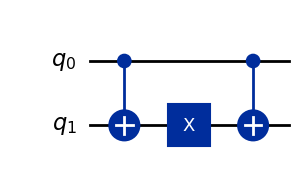

In [3]:
counter = 0
for idx in range(len(qc.data) - 1, 0, -1):
    if counter == 1:
        counter = 0
        del qc.data[idx]
        continue
    current_op = qc.data[idx][0]
    prev_op = qc.data[idx - 1][0]
    if current_op.name == prev_op.name and [q._index for q in qc.data[idx][1]] == [q._index for q in qc.data[idx - 1][1]]:
        # Remove consecutive duplicates
        del qc.data[idx]
        counter = 1

qc.draw('mpl')

In order to transpile a circuit, the following steps must be implemented:
1. Translate all gates into the native gateset
2. Choose a given ordering
    a. convert everything to swap gates
    b. minimize the number of swap gates
3. Find the best connectivity for this ordering
4. Repeat to find the best ordering and connectivity for a given algorithm

1. Translate all gates into the native gateset (here CZ, X90, Z)

In [4]:
# testing the equivalence library for the CNOT gate

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import CXGate, HGate, RYGate, RXGate, SwapGate
from qiskit.circuit.equivalence_library import EquivalenceLibrary
import numpy as np
pi = np.pi

#done: cnot, h, ry, rz, rx

#not done: xx, yy, zz, 

#to improve: swap, rx

# cnot

cnot = CXGate()

cx_eq = QuantumCircuit(2)
cx_eq.h(1)
cx_eq.cz(0, 1)
cx_eq.h(1) # I guess pass this first, then decompose the hadamard gates?

eq_lib = EquivalenceLibrary()

eq_lib.add_equivalence(cnot, cx_eq)

# h
h = HGate()

h_eq = QuantumCircuit(1)
h_eq.p(pi/2, 0) # not technically in our library; find additional gateset for this
h_eq.x(0)
h_eq.rz(pi/2, 0)
h_eq.x(0)

eq_lib.add_equivalence(h, h_eq)

# y
t = Parameter('t')
ry = RYGate(t)
y_eq = QuantumCircuit(1)
y_eq.x(0)
y_eq.rz(-t, 0)
y_eq.x(0)

eq_lib.add_equivalence(ry, y_eq)

# rx (must be a better way, we end up with X*Z*X, which can probably be expressed as another gate/phase.)
t = Parameter('t')
rx = RXGate(t)
x_eq = QuantumCircuit(1)
x_eq.ry(pi/2, 0)
x_eq.rz(t, 0)
x_eq.ry(pi/2, 0)

eq_lib.add_equivalence(rx, x_eq)

# # swap (also must have better form for this gateset)
# swap = SwapGate()
# swap_eq = QuantumCircuit(2)
# swap_eq.cx(0, 1)
# swap_eq.cx(1, 0)
# swap_eq.cx(0, 1)

# eq_lib.add_equivalence(swap, swap_eq)


In [5]:
# testing new circuit

circ = QuantumCircuit(2)
# swap as cx
circ.h(0)
print(circ.draw())

# transpile the circuit

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator


basis_gates = ['cz', 'x', 'rz', 'p', 'swap'] # phase and swap aren't actually in our gateset; currently just a crutch. the swap is used to find the best connectivity, then it can be transpiled. 
pm = PassManager()
pm.append(BasisTranslator(eq_lib, basis_gates))

transpiled_qc = pm.run(circ)

print(transpiled_qc.draw('mpl'))
# comment


     ┌───┐
q_0: ┤ H ├
     └───┘
q_1: ─────
          
Figure(454.517x200.667)


Collected functions

In [45]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def initialize_grid(l_x, l_y):
    G = nx.grid_2d_graph(l_y, l_x)
    labels = {node: i for i, node in enumerate(G.nodes())} # maps a node to a given label, so normal ordering
    # Update positions to be used for plotting
    pos = {(x, y): (y, -x) for x, y in G.nodes()} # check
    return G, labels, pos

# def initialize_full_grid(l_x, l_y):
#     G = nx.complete_graph(l_x*l_y)
#     labels = {node: i for i, node in enumerate(G.nodes())} # maps a node to a given label, so normal ordering
#     # Update positions to be used for plotting
#     print('nodes are', G.nodes())
#     pos = {(x, y): (y, -x) for x, y in G.nodes()} # check
#     return G, labels, pos

def draw_grid_with_labels(G, labels, pos): # removed shortest path highlight for now
    """Draw the grid with integer labels and highlight the paths."""
    plt.figure(figsize=(8, 8))
    # Draw nodes using the integer labels directly
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=2000,
             font_size=15)
    plt.show()


# added path labels
def find_all_shortest_paths(G, labels, start_label, end_label):
    """Find and visualize all shortest paths from start_label to end_label."""
    # Mapping from labels back to nodes for searching
    label_to_node = {label: node for node, label in labels.items()}
    start_node = label_to_node[start_label]
    end_node = label_to_node[end_label]

    paths = list(nx.all_shortest_paths(G, source=start_node, target=end_node))
    path_labels = [[labels[node] for node in path] for path in paths] # added len(path)
    # print(f"All shortest paths from {start_label} to {end_label}: {path_labels}")
    return paths, path_labels # added path_labels

# takes integer swap
def swap_labels(G, labels, pos, label1, label2):
    """Swap the labels of two nodes identified by their labels and redraw the graph."""
    node1 = next(node for node, label in labels.items() if label == label1)
    node2 = next(node for node, label in labels.items() if label == label2)

    # Swap the labels in the dictionary
    labels[node1], labels[node2] = labels[node2], labels[node1]

    # Redraw the graph with updated labels
    draw_grid_with_labels(G, labels, pos)

def swap_labels_return(G, labels, pos, label1, label2):
    labels2 = labels.copy()
    """Swap the labels of two nodes identified by their labels and redraw the graph."""
    node1 = next(node for node, label in labels.items() if label == label1)
    node2 = next(node for node, label in labels.items() if label == label2)

    # Swap the labels in the dictionary
    labels2[node1], labels2[node2] = labels2[node2], labels2[node1]

    # Redraw the graph with updated labels
    # draw_grid_with_labels(G, labels, pos)
    return labels2

def find_frequent_subpaths_grouped(paths, min_paths):
    all_subpaths = defaultdict(set)
    
    # Generate only subpaths that are pairs of nodes (exactly two nodes long)
    for path_index, path in enumerate(paths):
        for start in range(len(path) - 1):  # Adjust the loop to ensure only pairs are generated
            end = start + 2  # Fixed end to ensure the subpath is exactly two nodes long
            if end <= len(path):  # Ensure the slice is within the path length
                subpath = tuple(path[start:end])
                all_subpaths[subpath].add(path_index)
    
    # Collect frequent subpaths that appear in at least 'min_paths' different paths
    frequent_subpaths = defaultdict(list)
    for subpath, paths_indices in all_subpaths.items():
        if len(paths_indices) >= min_paths:
            subpath_count = len(paths_indices)
            frequent_subpaths[subpath_count].append(subpath)
    max_count = max(frequent_subpaths.keys(), default=0)

    return max_count, dict(frequent_subpaths) 

def get_swaps_paths(G, labels, pos, qubits):
    swaps = 0
    paths_ar = []
    for op in range(len(qubits)):
        qubit1, qubit2 = qubits[op]
        paths, path_labels = find_all_shortest_paths(G, labels, qubit1, qubit2)
        paths_ar.append(path_labels)
        swaps += len(paths[0]) - 2
    return swaps, paths_ar

    
def label_hash(labels):
    return ''.join([str(label[1]) for label in labels.items()])

def get_config_labels(subpaths, index, G, pos, labels):
    if index not in subpaths: # new line, idk if it will break everything... 
        return []
    num_max_paths = len(subpaths[index])

    new_labels = labels
    for n in range(num_max_paths):
        label1, label2 = subpaths[index][n]
        new_labels = swap_labels_return(G, new_labels, pos, label1, label2)
    return new_labels

def update_dict(dict, hash, G, labels, pos, swaps):
    if hash not in dict.keys():
        dict[hash] = {}
    dict[hash]["config"] = [G, pos, labels]
    dict[hash]['swaps'] = swaps 

    # make function to find the swaps for a given configuration

from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from collections import defaultdict


def get_swaps(circ, G, labels, pos):
    # find two-qubit gates, and add them to an array as the two nodes
    dag = circuit_to_dag(circ)
    ops = dag.two_qubit_ops() 
    qubits = []

    for op in range(len(ops)): # for two-qubit gates; extend to 3 qubits eventually
        qubits.append([ops[op].qargs[0]._index, ops[op].qargs[1]._index])
    #print(qubits)

    # initialize a dictionary to save the configurations and number of swaps
    dict_swaps = {}

    max_passes = 5
    max_tries = 5

    n = 0
    
    for n in range(max_passes):

    # find number of swaps and what to swap for old and new configuration
        swaps, paths_ar = get_swaps_paths(G, labels, pos, qubits)
        new_swaps = swaps # new line, might break everything... 
        all_paths = sum(paths_ar, []) # for some reason when I put it in the fct it doesn't work. check on it later ig
        maximum_count, frequent_subpaths = find_frequent_subpaths_grouped(all_paths, min_paths=2)
        if maximum_count == 0:
            break
        new_labels = get_config_labels(subpaths=frequent_subpaths, index=maximum_count, G=G, pos=pos, labels=labels)
        new_swaps, new_paths = get_swaps_paths(G, labels, pos, qubits)
        new_labels_hash = label_hash(new_labels)

        i = 1
        while new_swaps > swaps or new_labels_hash in dict_swaps.keys():
            index = maximum_count - i
            if index not in frequent_subpaths:
                continue
            new_labels = get_config_labels(subpaths=frequent_subpaths, index=index, G=G, pos=pos, labels=new_labels)
            new_swaps, new_paths = get_swaps_paths(G, labels, pos, qubits)
            new_labels_hash = label_hash(new_labels)
            i+= 1
            if i < maximum_count:
                break
        
        # new_swaps <= swaps, not yet in dictionary
        hash = new_labels_hash
        labels = new_labels
        swaps = new_swaps
        update_dict(dict_swaps, hash, G, labels, pos, swaps)
    return new_swaps
    #draw_grid_with_labels(G=G, labels=labels, pos=pos)

def create_random_circuit(circuit_depth, qubit_number, qc):

    # adds random gate given some circuit

    # qc = QuantumCircuit(qubit_number)
    for i in range(circuit_depth):
        m = np.random.randint(1, 2)
        number1 = np.random.randint(0, qubit_number)
        if m == 0:
            if number1 % 2 == 0:
                qc.h(number1)
            else:
                qc.x(number1)
        # single qubit loop
        elif m == 1:
        # two-qubit loop
        # choose two random nodes, calculate the path length between the cross-resonant gate vs normal configuration
            # print(number1)
            number2 = np.random.randint(0, qubit_number)
            while number2 == number1:
                number2 = np.random.randint(0, qubit_number)
            qc.cx(number1, number2)
    return qc

def append_random_gate(qc):
    # make it for more general set of gates
    circuit_depth = qc.depth()
    qubit_number = qc.num_qubits

    # adds random gate given some circuit

    # qc = QuantumCircuit(qubit_number)

    m = np.random.randint(1, 2) # forcing 1
    number1 = np.random.randint(0, qubit_number)
    if m == 0:
        if number1 % 2 == 0:
            qc.h(number1)
        else:
            qc.x(number1)
    # single qubit loop
    elif m == 1:
    # two-qubit loop
    # choose two random nodes, calculate the path length between the cross-resonant gate vs normal configuration
        # print(number1)
        number2 = np.random.randint(0, qubit_number)
        while number2 == number1:
            number2 = np.random.randint(0, qubit_number)
        qc.cx(number1, number2)
    return qc


Preliminary 'metropolis algorithm'

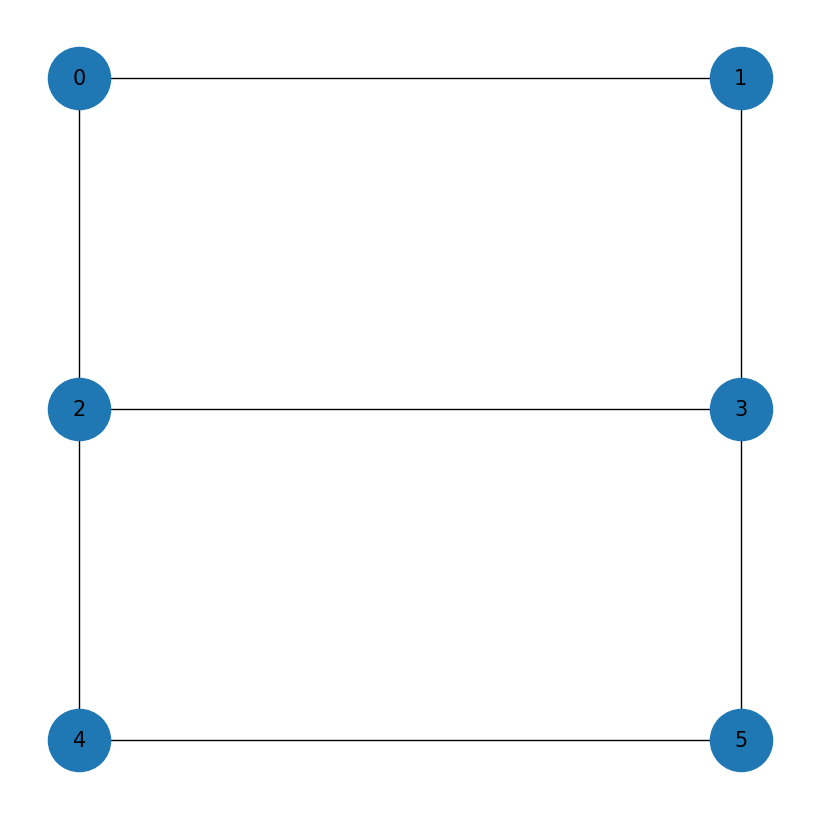

[[0, 1], [0, 4], [0, 5]]


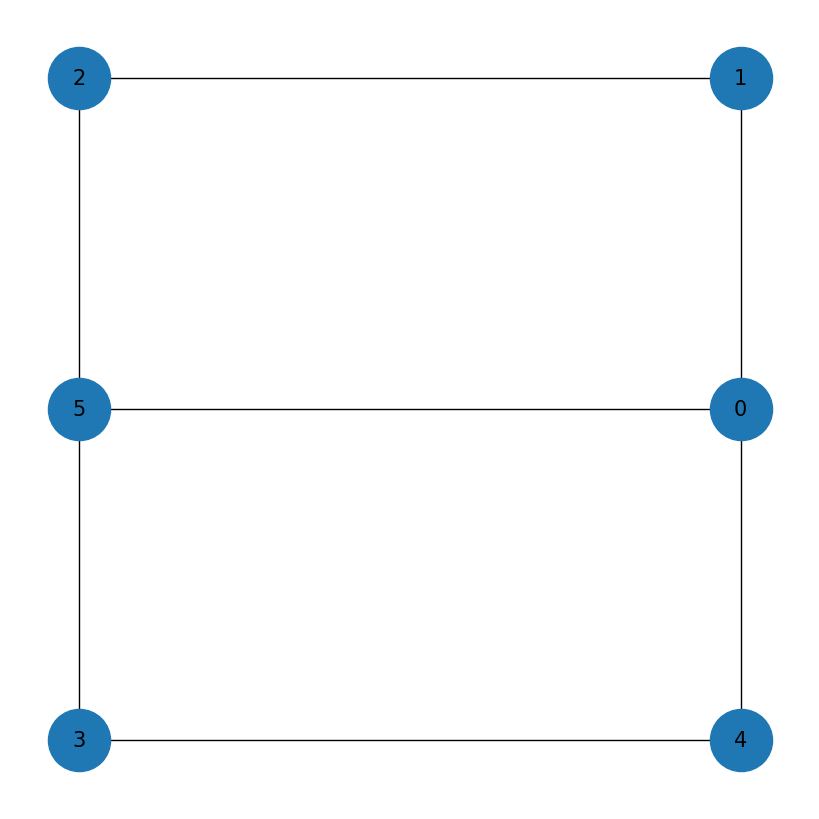

In [7]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from collections import defaultdict
# parameters
l_x = 2
l_y = 3


# initialize graph to test circuit
G, labels, pos = initialize_grid(l_x, l_y)
draw_grid_with_labels(G, labels, pos)

# create a circuit to test 
qc = QuantumCircuit(l_x*l_y)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 4)
qc.cx(0, 5)

# find two-qubit gates, and add them to an array as the two nodes
dag = circuit_to_dag(qc)
ops = dag.two_qubit_ops() 
qubits = []

for op in range(len(ops)): # for two-qubit gates; extend to 3 qubits eventually
    qubits.append([ops[op].qargs[0]._index, ops[op].qargs[1]._index])
print(qubits)

# initialize a dictionary to save the configurations and number of swaps
dict_swaps = {}

max_passes = 5
max_tries = 5

n = 0

for n in range(max_passes):

# find number of swaps and what to swap for old and new configuration
    swaps, paths_ar = get_swaps_paths(G, labels, pos, qubits)
    all_paths = sum(paths_ar, []) # for some reason when I put it in the fct it doesn't work. check on it later ig
    maximum_count, frequent_subpaths = find_frequent_subpaths_grouped(all_paths, min_paths=2)
    if maximum_count == 0:
        break
    new_labels = get_config_labels(subpaths=frequent_subpaths, index=maximum_count, G=G, pos=pos, labels=labels)
    new_swaps, new_paths = get_swaps_paths(G, labels, pos, qubits)
    new_labels_hash = label_hash(new_labels)

    i = 1
    while new_swaps > swaps or new_labels_hash in dict_swaps.keys():
        new_labels = get_config_labels(subpaths=frequent_subpaths, index=maximum_count - i, G=G, pos=pos, labels=new_labels)
        new_swaps, new_paths = get_swaps_paths(G, labels, pos, qubits)
        new_labels_hash = label_hash(new_labels)
        i+= 1
        if i < maximum_count:
            break
    
    # new_swaps <= swaps, not yet in dictionary
    hash = new_labels_hash
    labels = new_labels
    swaps = new_swaps
    update_dict(dict_swaps, hash, G, labels, pos, swaps)

draw_grid_with_labels(G=G, labels=labels, pos=pos)



More tests to make sure it works 
(doesn't for 1, 4 for some reason. will have to investigate. )

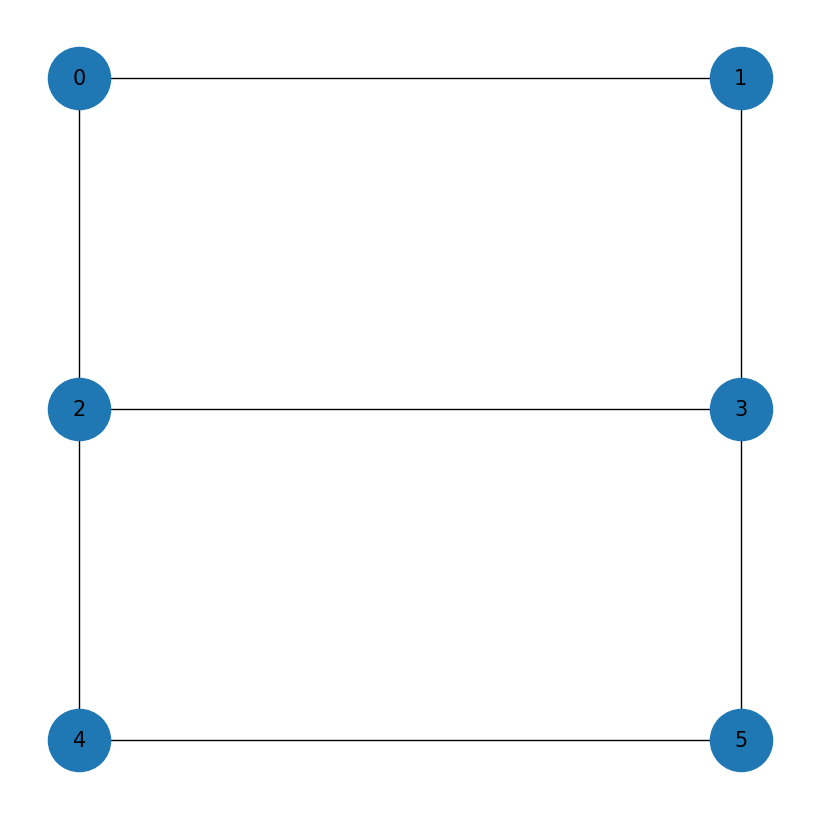

[[0, 1], [0, 4], [0, 5], [1, 2], [1, 3]]


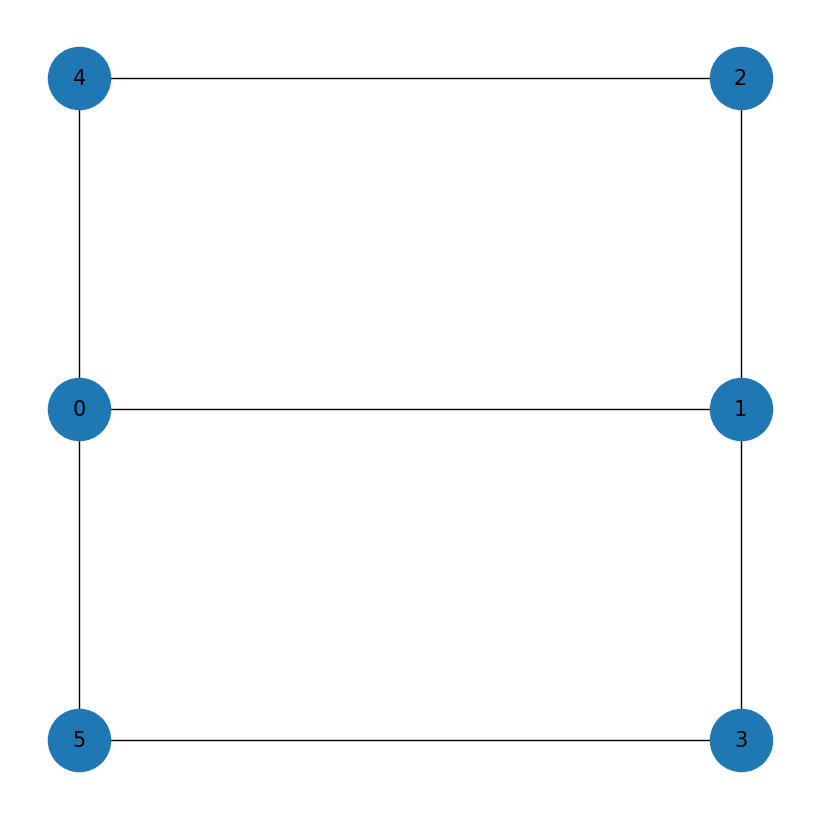

In [8]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from collections import defaultdict
# parameters
l_x = 2
l_y = 3


# initialize graph to test circuit
G, labels, pos = initialize_grid(l_x, l_y)
draw_grid_with_labels(G, labels, pos)

# create a circuit to test 
qc = QuantumCircuit(l_x*l_y)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 4)
qc.cx(0, 5)
qc.cx(1, 2)
qc.cx(1, 3) # added more gates

# find two-qubit gates, and add them to an array as the two nodes
dag = circuit_to_dag(qc)
ops = dag.two_qubit_ops() 
qubits = []

for op in range(len(ops)): # for two-qubit gates; extend to 3 qubits eventually
    qubits.append([ops[op].qargs[0]._index, ops[op].qargs[1]._index])
print(qubits)

# initialize a dictionary to save the configurations and number of swaps
dict_swaps = {}

max_passes = 10
max_tries = 5

n = 0

for n in range(max_passes):

# find number of swaps and what to swap for old and new configuration
    swaps, paths_ar = get_swaps_paths(G, labels, pos, qubits)
    all_paths = sum(paths_ar, []) # for some reason when I put it in the fct it doesn't work. check on it later ig
    maximum_count, frequent_subpaths = find_frequent_subpaths_grouped(all_paths, min_paths=2)
    if maximum_count == 0:
        break
    new_labels = get_config_labels(subpaths=frequent_subpaths, index=maximum_count, G=G, pos=pos, labels=labels)
    new_swaps, new_paths = get_swaps_paths(G, labels, pos, qubits)
    new_labels_hash = label_hash(new_labels)

    i = 1
    while new_swaps > swaps or new_labels_hash in dict_swaps.keys():
        new_labels = get_config_labels(subpaths=frequent_subpaths, index=maximum_count - i, G=G, pos=pos, labels=new_labels)
        new_swaps, new_paths = get_swaps_paths(G, labels, pos, qubits)
        new_labels_hash = label_hash(new_labels)
        i+= 1
        if i < maximum_count:
            break
    
    # new_swaps <= swaps, not yet in dictionary
    hash = new_labels_hash
    labels = new_labels
    swaps = new_swaps
    update_dict(dict_swaps, hash, G, labels, pos, swaps)

draw_grid_with_labels(G=G, labels=labels, pos=pos)



In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def initialize_grid(l_x, l_y):
    # Create a standard 2D grid graph
    G = nx.grid_2d_graph(l_y, l_x)
    
    # Adding diagonal edges to create a triangular grid pattern
    # for x in range(l_x):
    #     for y in range(l_y):
    #         # Northeast diagonal
    #         if x + 1 < l_x and y + 1 < l_y:
    #             G.add_edge((x, y), (x + 1, y + 1))
    #         # Southeast diagonal
    #         if x + 1 < l_x and y - 1 >= 0:
    #             G.add_edge((x, y), (x + 1, y - 1))

    # Maps a node to a given label, normal ordering
    labels = {node: i for i, node in enumerate(G.nodes())}
    # Update positions to be used for plotting (y, -x for visual orientation)
    pos = {(x, y): (y, -x) for x, y in G.nodes()}
    return G, labels, pos



def draw_grid_with_labels(G, labels, pos): # removed shortest path highlight for now
    """Draw the grid with integer labels and highlight the paths."""
    plt.figure(figsize=(8, 8))
    # Draw nodes using the integer labels directly
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=2000,
             font_size=15)
    plt.show()

G, labels, pos = initialize_grid(2, 3)
G.add_edge((0, 0), (1, 1)) # change this so it's more general. This is for the first diagonal. 
# nx.add_path(G, [0, 4])
#draw_grid_with_labels(G, labels, pos)


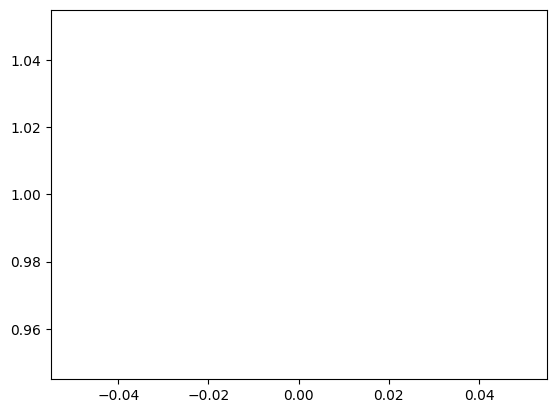

In [15]:

# nswaps_og = get_swaps()


# parameters
l_x = 2
l_y = 3


# initialize simple (no cross-resonance) graph to test circuit
G, labels, pos = initialize_grid(l_x, l_y)
# draw_grid_with_labels(G, labels, pos)

# initialize triangle graph to test circuit

Gn, labelsn, posn = initialize_grid(2, 3)
Gn.add_edge((0, 0), (1, 1)) # change this so it's more general. This is for the first diagonal. 
# draw_grid_with_labels(Gn, labelsn, posn)

# create a randomized circuit to test 
# qc = create_random_circuit(circuit_depth=6, qubit_number=6)
# print(qc.draw())


old_swaps = []
new_swaps = []

total_depth = 6
Ns = np.arange(0, total_depth, 1)

for n in range(total_depth):
    
    # initialize simple (no cross-resonance) graph to test circuit
    G, labels, pos = initialize_grid(l_x, l_y)
    # draw_grid_with_labels(G, labels, pos)

    # initialize triangle graph to test circuit

    Gn, labelsn, posn = initialize_grid(2, 3)
    Gn.add_edge((0, 0), (1, 1)) # change this so it's more general. This is for the first diagonal. 
    # draw_grid_with_labels(Gn, labelsn, posn)

    # create a randomized circuit to test 
    qc = create_random_circuit(circuit_depth=6, qubit_number=6)
    # print(qc.draw())
    # print("old_swaps =", old_swaps)
    # print('new swaps are', new_swaps)
    old_swaps.append(get_swaps(circ=qc, G=G, labels=labels, pos=pos))
# print('final swaps is', test_swaps)
    new_swaps.append(get_swaps(circ=qc, G=Gn, labels=labelsn, pos=posn))
# print('final swaps is', test_swapsn)

plt.plot(Ns, old_swaps, label='no diagonal')
plt.plot(Ns, new_swaps, label='single diagonal')
plt.show()


In [11]:

swap_dict = {}

swap_dict['old_swaps'] = {}
swap_dict['new_swaps'] = {}

average_number = 2
total_depth = 10
qubit_number = 6
qc = QuantumCircuit(qubit_number)

Ns = np.arange(1, total_depth + 1, 1)
print(Ns)
old_swaps_avg = []
new_swaps_avg = []


for n in range(total_depth):
    # print('n=', n)
    if n not in swap_dict['old_swaps'].keys():
        swap_dict['old_swaps'][n] = 0
    if n not in swap_dict['new_swaps'].keys():
        swap_dict['new_swaps'][n] = 0
    for m in range(1, average_number):
        # print('m=', m)
        # initialize simple (no cross-resonance) graph to test circuit
        G, labels, pos = initialize_grid(l_x, l_y)
        # draw_grid_with_labels(G, labels, pos)

        # initialize triangle graph to test circuit

        Gn, labelsn, posn = initialize_grid(2, 3)
        # Gn = nx.all_pairs_node_connectivity(G)
        # draw_grid_with_labels(Gn, labels, pos)
        Gn.add_edge((0, 0), (1, 1)) # change this so it's more general. This is for the first diagonal. 
        Gn.add_edge((0, 1), (1, 0))
        Gn.add_edge((1, 0), (2, 1))
        Gn.add_edge((2, 0), (1, 1))
        # draw_grid_with_labels(Gn, labelsn, posn)

        # create a randomized circuit to test 
        qc = create_random_circuit(circuit_depth=n, qubit_number=6, qc=qc)
        # qc.h(0)
        print(qc.draw())
        # print(qc.draw())
        # print("old_swaps =", old_swaps)
        # print('new swaps are', new_swaps)
        swap_dict['old_swaps'][n]+= (get_swaps(circ=qc, G=G, labels=labels, pos=pos))/m
        # print('final swaps is', test_swaps)
        swap_dict['new_swaps'][n]+= (get_swaps(circ=qc, G=G, labels=labels, pos=pos))/m
        # print('final swaps is', test_swapsn)
    old_swaps_avg.append(swap_dict['old_swaps'][n])
    new_swaps_avg.append(swap_dict['new_swaps'][n])


plt.plot(Ns, old_swaps_avg, label='no diagonal')
plt.plot(Ns, new_swaps_avg, label='single diagonal')
plt.legend()
plt.show()

[ 1  2  3  4  5  6  7  8  9 10]
     
q_0: 
     
q_1: 
     
q_2: 
     
q_3: 
     
q_4: 
     
q_5: 
     
          
q_0: ─────
          
q_1: ──■──
       │  
q_2: ──┼──
     ┌─┴─┐
q_3: ┤ X ├
     └───┘
q_4: ─────
          
q_5: ─────
          
                    
q_0: ───────────────
          ┌───┐┌───┐
q_1: ──■──┤ X ├┤ X ├
       │  └─┬─┘└─┬─┘
q_2: ──┼────■────┼──
     ┌─┴─┐       │  
q_3: ┤ X ├───────┼──
     └───┘       │  
q_4: ────────────■──
                    
q_5: ───────────────
                    
                              ┌───┐
q_0: ─────────────────────────┤ X ├
          ┌───┐┌───┐┌───┐     └─┬─┘
q_1: ──■──┤ X ├┤ X ├┤ X ├──■────■──
       │  └─┬─┘└─┬─┘└─┬─┘┌─┴─┐     
q_2: ──┼────■────┼────■──┤ X ├─────
     ┌─┴─┐       │       └───┘     
q_3: ┤ X ├───────┼─────────────────
     └───┘       │                 
q_4: ────────────■─────────────────
                                   
q_5: ──────────────────────────────
                                   


KeyboardInterrupt: 

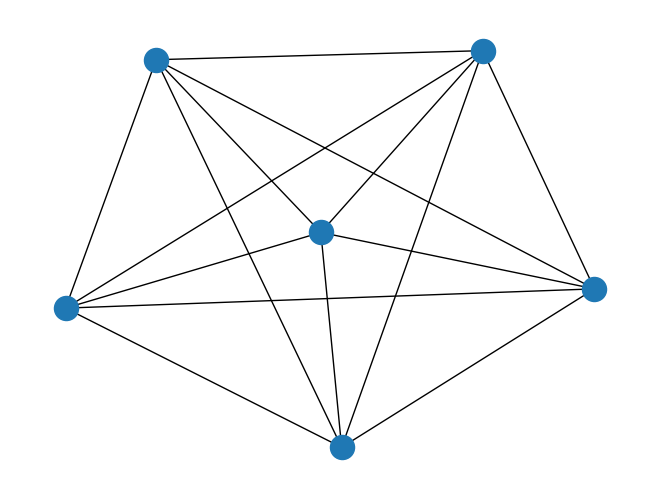

In [ ]:
Gn = nx.complete_graph(6)
nx.draw(Gn)

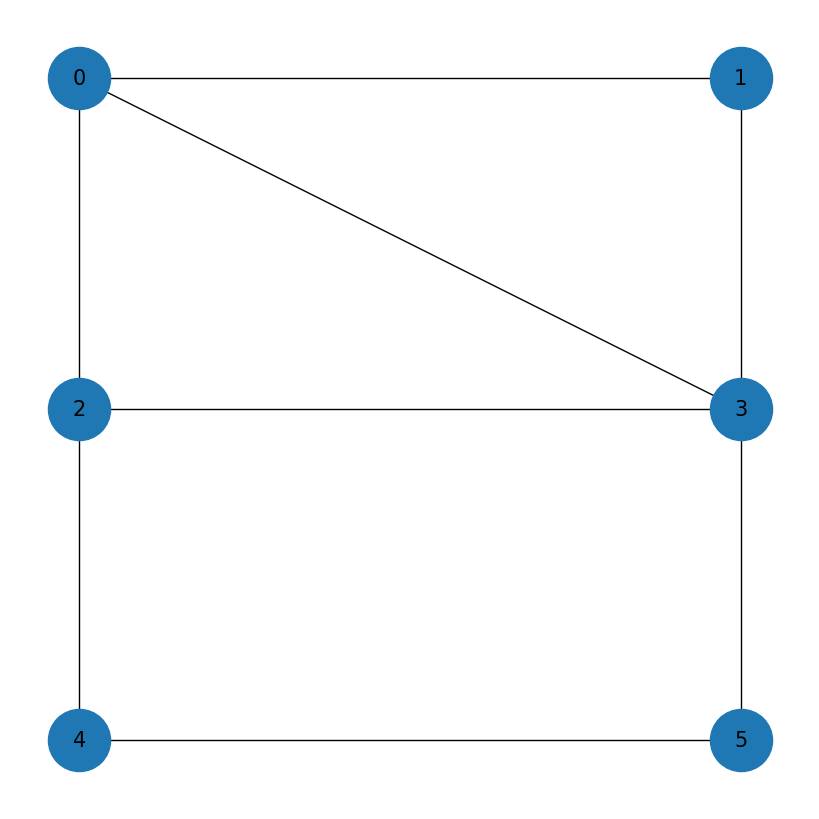

[0 1]


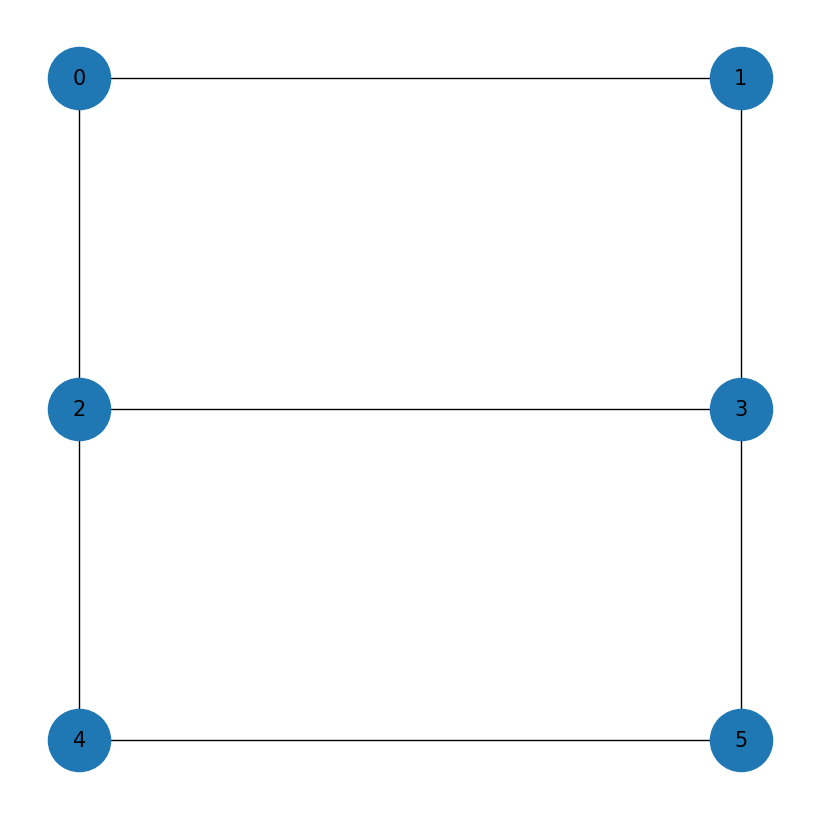

1
0


In [41]:
# parameters
l_x = 2
l_y = 3
num_qub = l_x*l_y

# initialize simple (no cross-resonance) graph to test circuit
G, labels, pos = initialize_grid(l_x, l_y)
# draw_grid_with_labels(G, labels, pos)

# initialize triangle graph to test circuit
Gn, labelsn, posn = initialize_grid(2, 3)
Gn.add_edge((0, 0), (1, 1)) # change this so it's more general. This is for the first diagonal. 
draw_grid_with_labels(Gn, labelsn, posn)

# create a randomized circuit to test 
# qc = create_random_circuit(circuit_depth=6, qubit_number=6)
# print(qc.draw())

# make circuit that favors the diagonal configuration
qc = QuantumCircuit(num_qub)
qc.cx(0, 3)

old_swaps = []
new_swaps = []

total_depth = qc.depth()

Ns = np.arange(0, total_depth + 1, 1, int)
print(Ns)

# in the following, we want to count the number of swaps necessary for a normal
# configuration and the cross-resonance gate. We don't want to average it yet, 
# so we'll do it for one qubit. 


# initialize simple (no cross-resonance) graph to test circuit
G, labels, pos = initialize_grid(l_x, l_y)
draw_grid_with_labels(G, labels, pos)


# initialize triangle graph to test circuit

Gn, labelsn, posn = initialize_grid(2, 3)
Gn.add_edge((0, 0), (1, 1)) # change this so it's more general. This is for the first diagonal. 
# draw_grid_with_labels(Gn, labelsn, posn)

for n in range(total_depth):
    old_swap = get_swaps(circ=qc, G=G, labels=labels, pos=pos)
    print(old_swap)
    # old_swaps.append(get_swaps(circ=qc, G=G, labels=labels, pos=pos))
    # print('final swaps is', test_swaps)
    new_swap = get_swaps(circ=qc, G=Gn, labels=labelsn, pos=posn)
    print(new_swap)
    # new_swaps.append(get_swaps(circ=qc, G=Gn, labels=labelsn, pos=posn))
    # print('final swaps is', test_swapsn)

# print('old swaps are', old_swaps, 'new swaps are', new_swaps)

# for n in range(total_depth):
    
#     # initialize simple (no cross-resonance) graph to test circuit
#     G, labels, pos = initialize_grid(l_x, l_y)
#     # draw_grid_with_labels(G, labels, pos)

#     # initialize triangle graph to test circuit

#     Gn, labelsn, posn = initialize_grid(2, 3)
#     Gn.add_edge((0, 0), (1, 1)) # change this so it's more general. This is for the first diagonal. 
#     # draw_grid_with_labels(Gn, labelsn, posn)

#     # create a randomized circuit to test 
#     qc = create_random_circuit(circuit_depth=6, qubit_number=6)
#     # print(qc.draw())
#     # print("old_swaps =", old_swaps)
#     # print('new swaps are', new_swaps)
#     old_swaps.append(get_swaps(circ=qc, G=G, labels=labels, pos=pos))
# # print('final swaps is', test_swaps)
#     new_swaps.append(get_swaps(circ=qc, G=Gn, labels=labelsn, pos=posn))
# # print('final swaps is', test_swapsn)

# plt.plot(Ns, old_swaps, label='no diagonal')
# plt.plot(Ns, new_swaps, label='single diagonal')
# plt.show()


In [78]:
# parameters
l_x = 2
l_y = 3
num_qub = l_x*l_y

# initialize simple (no cross-resonance) graph to test circuit
G, labels, pos = initialize_grid(l_x, l_y)
# draw_grid_with_labels(G, labels, pos)

# initialize triangle graph to test circuit
Gn, labelsn, posn = initialize_grid(2, 3)
Gn.add_edge((0, 0), (1, 1)) # change this so it's more general. This is for the first diagonal. 
# draw_grid_with_labels(Gn, labelsn, posn)

# create a randomized circuit to test 
# qc = create_random_circuit(circuit_depth=6, qubit_number=6)
# print(qc.draw())

# make circuit that favors the diagonal configuration
qc = QuantumCircuit(num_qub)
total_depth = 20

old_swaps = []
new_swaps = []



Ns = np.arange(0, total_depth + 1, 1, int)
# print(Ns)

# in the following, we want to count the number of swaps necessary for a normal
# configuration and the cross-resonance gate and average it for a random circuit over
# an increasing circuit depth. The circuit is blank, and for each new depth, we draw a
# random gate and add it to the circuit. 

swap_diff = 0
# unaveraged 
for m in range(10):
    for n in range(total_depth):
        qc = QuantumCircuit(num_qub)
        qc = append_random_gate(qc)
        old_swap = get_swaps(circ=qc, G=G, labels=labels, pos=pos)
        # print(old_swap)
        old_swaps.append(get_swaps(circ=qc, G=G, labels=labels, pos=pos))
        # print('final swaps is', test_swaps)
        new_swap = get_swaps(circ=qc, G=Gn, labels=labelsn, pos=posn)
        # print(new_swap)
        new_swaps.append(get_swaps(circ=qc, G=Gn, labels=labelsn, pos=posn))
        # print('final swaps is', test_swapsn)

    # print('old swaps are', old_swaps, 'new swaps are', new_swaps)
        swap_diff += np.sum(np.array(old_swaps)) - np.sum(np.array(new_swaps))

print('avgd swap diff is', swap_diff)

# for n in range(total_depth):
    
#     # initialize simple (no cross-resonance) graph to test circuit
#     G, labels, pos = initialize_grid(l_x, l_y)
#     # draw_grid_with_labels(G, labels, pos)

#     # initialize triangle graph to test circuit

#     Gn, labelsn, posn = initialize_grid(2, 3)
#     Gn.add_edge((0, 0), (1, 1)) # change this so it's more general. This is for the first diagonal. 
#     # draw_grid_with_labels(Gn, labelsn, posn)

#     # create a randomized circuit to test 
#     qc = create_random_circuit(circuit_depth=6, qubit_number=6)
#     # print(qc.draw())
#     # print("old_swaps =", old_swaps)
#     # print('new swaps are', new_swaps)
#     old_swaps.append(get_swaps(circ=qc, G=G, labels=labels, pos=pos))
# # print('final swaps is', test_swaps)
#     new_swaps.append(get_swaps(circ=qc, G=Gn, labels=labelsn, pos=posn))
# # print('final swaps is', test_swapsn)

# plt.plot(Ns, old_swaps, label='no diagonal')
# plt.plot(Ns, new_swaps, label='single diagonal')
# plt.show()


avgd swap diff is -220
